<a href="https://colab.research.google.com/github/HFooladi/GNNs-For-Chemists/blob/main/notebooks/01_GNN_representation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Neural Networks

Historically, the biggest difficulty for machine learning with molecules was the choice and computation of "descriptors". Graph neural networks (GNNs) are a category of deep neural networks whose inputs are graphs and provide a way around the choice of descriptors. A GNN can take a molecule directly as input.

After completing this chapter, you should be able to

  * Represent a molecule in a graph
  * Distinguish between graph, edge, and node features


GNNs are specific layers that input a graph and output a graph. You can find reviews of GNNs in Dwivedi *et al.*{cite}`dwivedi2020benchmarking`, Bronstein *et al.*{cite}`bronstein2017geometric`, and  Wu *et al.*{cite}`wu2020comprehensive`. GNNs can be used for everything from coarse-grained molecular dynamics {cite}`li2020graph` to predicting NMR chemical shifts {cite}`yang2020predicting` to modeling dynamics of solids {cite}`xie2019graph`. Before we dive too deep into them, we must first understand how a graph is represented in a computer and how molecules are converted into graphs.

You can find an interactive introductory article on graphs and graph neural networks at [distill.pub](https://distill.pub/2021/gnn-intro/) {cite}`sanchez-lengeling2021a`. Most current research in GNNs is done with specialized deep learning libraries for graphs. The most common are [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/), [Deep Graph library](https://www.dgl.ai/), [DIG](https://github.com/divelab/DIG), [Spektral](https://graphneural.network/), and [TensorFlow GNNS](https://github.com/tensorflow/gnn).

In [1]:
!wget https://github.com/whitead/dmol-book/blob/main/dl/methanol.jpg?raw=true -O ../content/methanol.jpg

--2025-04-07 13:37:10--  https://github.com/whitead/dmol-book/blob/main/dl/methanol.jpg?raw=true
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/whitead/dmol-book/raw/refs/heads/main/dl/methanol.jpg [following]
--2025-04-07 13:37:10--  https://github.com/whitead/dmol-book/raw/refs/heads/main/dl/methanol.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/whitead/dmol-book/refs/heads/main/dl/methanol.jpg [following]
--2025-04-07 13:37:10--  https://raw.githubusercontent.com/whitead/dmol-book/refs/heads/main/dl/methanol.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.

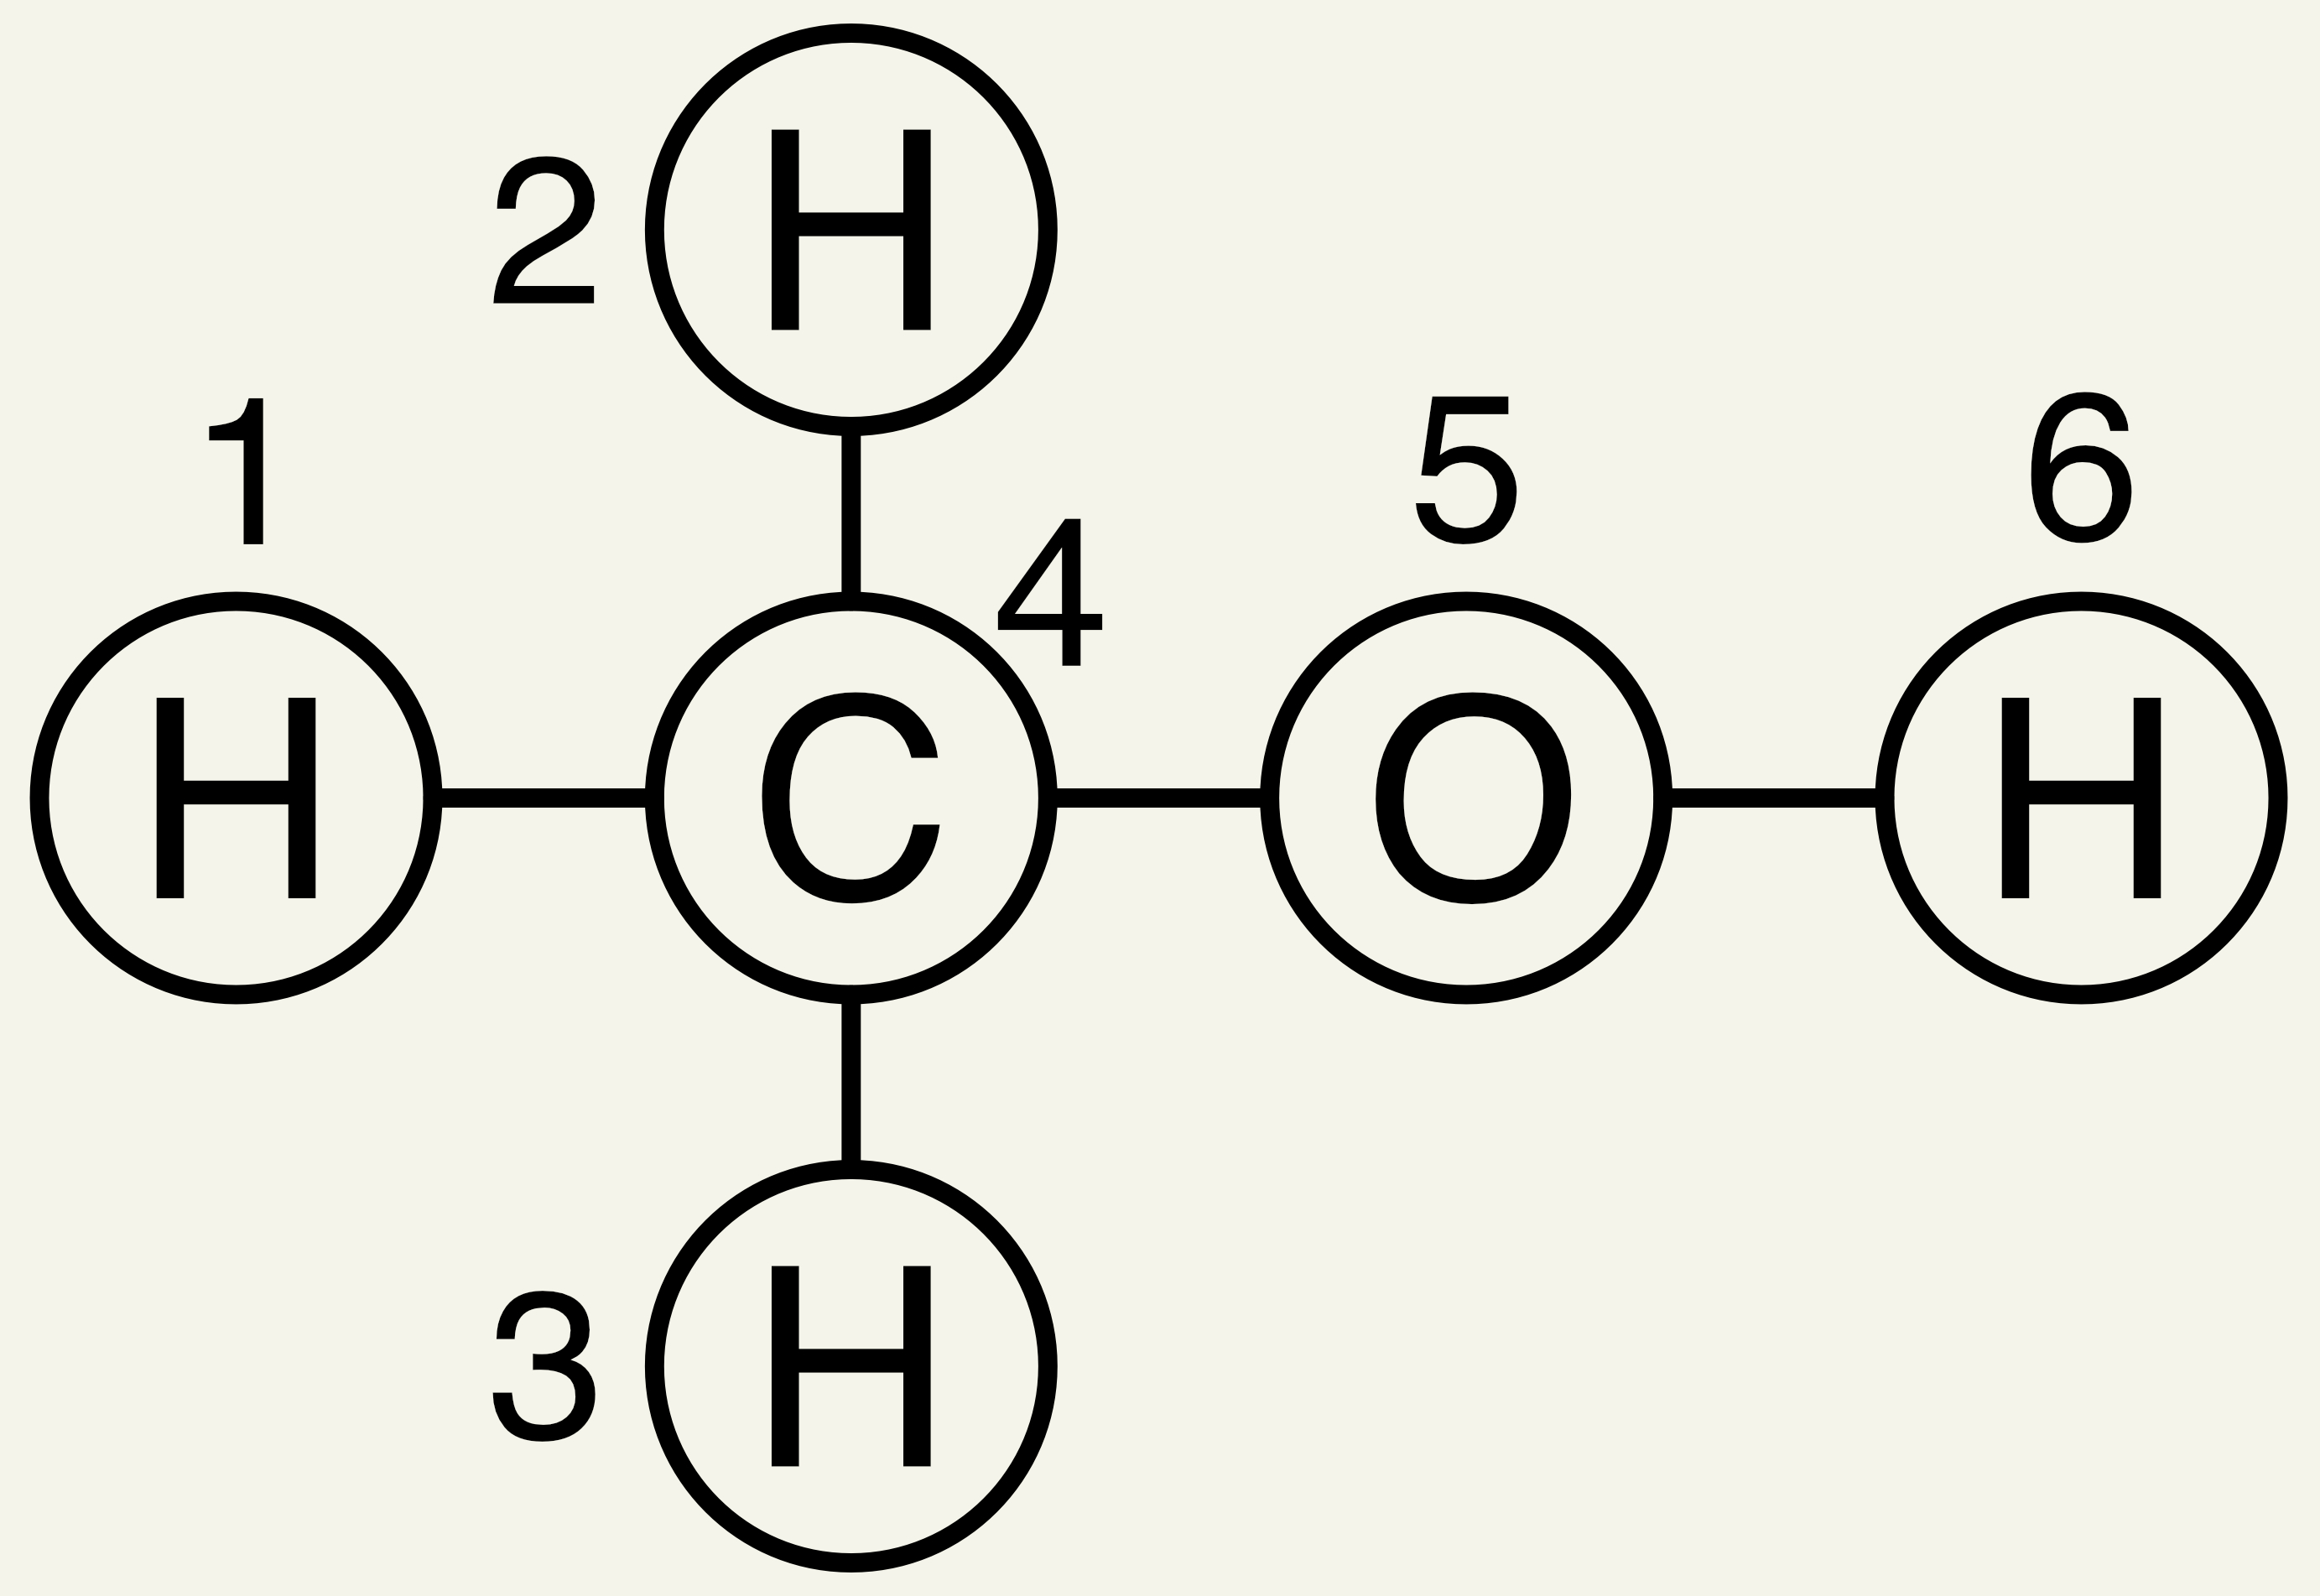

In [2]:
from PIL import Image

img = Image.open('../content/methanol.jpg')
display(img)

## Representing a Graph

A graph $\mathbf{G}$ is a set of nodes $\mathbf{V}$ and edges $\mathbf{E}$. In our setting, node $i$ is defined by a vector $\vec{v}_i$, so that the set of nodes can be written as a rank 2 tensor. The edges can be represented as an adjacency matrix $\mathbf{E}$, where if $e_{ij} = 1$ then nodes $i$ and $j$ are connected by an edge. In many fields, graphs are often immediately simplified to be directed and acyclic, which simplifies things. Molecules are instead undirected and have cycles (rings). Thus, our adjacency matrices are always symmetric $e_{ij} = e_{ji}$ because there is no concept of direction in chemical bonds. Often our edges themselves have features, so that $e_{ij}$ is itself a vector. Then the adjacency matrix becomes a rank 3 tensor. Examples of edge features might be covalent bond order or distance between two nodes.



Let's see how a graph can be constructed from a molecule. Consider methanol, shown in the figure. I've numbered the atoms so that we have an order for defining the nodes/edges. First, the node features. You can use anything for node features, but often we'll begin with one-hot encoded feature vectors:

| Node | C  | H  | O  |
|:-----|----|----|---:|
| 1    | 0  | 1  |  0 |
| 2    | 0  | 1  |  0 |
| 3    | 0  | 1  |  0 |
| 4    | 1  | 0  |  0 |
| 5    | 0  | 0  |  1 |
| 6    | 0  | 1  |  0 |

$\mathbf{V}$ will be the combined feature vectors of these nodes. The adjacency matrix $\mathbf{E}$ will look like:


|    | 1  | 2  | 3  | 4  | 5  | 6  |
|:---|----|----|----|----|----|---:|
| 1  | 0  | 0  | 0  | 1  | 0  |  0 |
| 2  | 0  | 0  | 0  | 1  | 0  |  0 |
| 3  | 0  | 0  | 0  | 1  | 0  |  0 |
| 4  | 1  | 1  | 1  | 0  | 1  |  0 |
| 5  | 0  | 0  | 0  | 1  | 0  |  1 |
| 6  | 0  | 0  | 0  | 0  | 1  |  0 |


Take a moment to understand these two. For example, notice that rows 1, 2, and 3 only have the 4th column as non-zero. That's because atoms 1-3 are bonded only to carbon (atom 4). Also, the diagonal is always 0 because atoms cannot be bonded with themselves.

You can find a similar process for converting crystals into graphs in Xie et al. {cite}`Xie2018Crystal`. We'll now begin with a function which can convert a smiles string into this representation.

In [3]:
!pip install rdkit myst_nb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.3/34.3 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.6/84.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.8 MB/s eta 0:00:00


In [4]:
import matplotlib.pyplot as plt # plotting
import matplotlib as mpl # plotting
import numpy as np # array manipulation
import tensorflow as tf
import pandas as pd # dataframe manipulation
import rdkit, rdkit.Chem, rdkit.Chem.rdDepictor, rdkit.Chem.Draw # chemical processing
import networkx as nx # visualization

In [5]:
soldata = pd.read_csv(
    "https://github.com/whitead/dmol-book/raw/main/data/curated-solubility-dataset.csv"
)
np.random.seed(0)
my_elements = { 6: "C",  8: "O", 1: "H"}

The cell below defines our function `smiles2graph`. This creates one-hot node feature vectors for the element H, O, and C. It also creates an adjacency tensor with one-hot bond order being the feature vector.

In [6]:
def smiles2graph(sml):
    """Argument for the smiles2graph function should be a valid SMILES sequence
    returns: the graph
    """
    m = rdkit.Chem.MolFromSmiles(sml)
    m = rdkit.Chem.AddHs(m)
    order_string = {
        rdkit.Chem.rdchem.BondType.SINGLE: 1,
        rdkit.Chem.rdchem.BondType.DOUBLE: 2,
        rdkit.Chem.rdchem.BondType.TRIPLE: 3,
        rdkit.Chem.rdchem.BondType.AROMATIC: 4,
    }
    N = len(list(m.GetAtoms()))
    nodes = np.zeros((N, len(my_elements)))
    lookup = list(my_elements.keys())
    for i in m.GetAtoms():
        nodes[i.GetIdx(), lookup.index(i.GetAtomicNum())] = 1

    adj = np.zeros((N, N, 5))
    for j in m.GetBonds():
        u = min(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        v = max(j.GetBeginAtomIdx(), j.GetEndAtomIdx())
        order = j.GetBondType()
        if order in order_string:
            order = order_string[order]
        else:
            raise Warning("Ignoring bond order" + order)
        adj[u, v, order] = 1
        adj[v, u, order] = 1
    return nodes, adj

In [7]:
nodes, adj = smiles2graph("CO")
nodes
## number of rows are the number of atoms in the moelcule, and the number of columns are the features for each node

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [8]:
adjacancy = adj[:,:,0] + adj[:,:,1] + adj[:,:,2] + adj[:,:,3] + adj[:,:,4]
adjacancy

array([[0., 1., 1., 1., 1., 0.],
       [1., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])

### Exercise
1- Write code to create the adjacancy list for the ethanol molecule.

Now we want to show the methanol molecule with the features on top of each nodes (atoms)

  if event.key is 'enter':



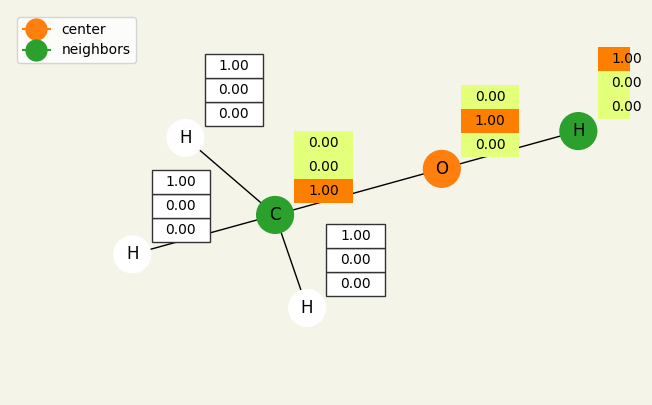

In [9]:
# THIS CELL IS USED TO GENERATE A FIGURE
# AND NOT RELATED TO CHAPTER
# YOU CAN SKIP IT
from myst_nb import glue
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage


def draw_vector(x, y, s, v, ax, cmap, **kwargs):
    x += s / 2
    y += s / 2
    for vi in v:
        if cmap is not None:
            ax.add_patch(
                mpl.patches.Rectangle((x, y), s * 1.5, s, facecolor=cmap(vi), **kwargs)
            )
        else:
            ax.add_patch(
                mpl.patches.Rectangle(
                    (x, y), s * 1.5, s, facecolor="#FFF", edgecolor="#333", **kwargs
                )
            )
        ax.text(
            x + s * 1.5 / 2,
            y + s / 2,
            "{:.2f}".format(vi),
            verticalalignment="center",
            horizontalalignment="center",
        )
        y += s


def draw_key(x, y, s, v, ax, cmap, **kwargs):
    x += s / 2
    y += s / 2
    for vi in v:
        ax.add_patch(
            mpl.patches.Rectangle((x, y), s * 1.5, s, facecolor=cmap(1.0), **kwargs)
        )
        ax.text(
            x + s * 1.5 / 2,
            y + s / 2,
            vi,
            verticalalignment="center",
            horizontalalignment="center",
        )
        y += s
    ax.text(
        x, y + s / 2, "Key:", verticalalignment="center", horizontalalignment="left"
    )


def draw(
    nodes, adj, ax, highlight=None, key=False, labels=None, mask=None, draw_nodes=None
):
    G = nx.Graph()
    for i in range(adj.shape[0]):
        for j in range(adj.shape[0]):
            if np.any(adj[i, j]):
                G.add_edge(i, j)
    if mask is None:
        mask = [True] * len(G)
    if draw_nodes is None:
        draw_nodes = nodes
    # go from atomic number to element
    elements = np.argmax(draw_nodes, axis=-1)
    el_labels = {i: list(my_elements.values())[e] for i, e in enumerate(elements)}
    try:
        pos = nx.nx_agraph.graphviz_layout(G, prog="sfdp")
    except ImportError:
        pos = nx.spring_layout(G, iterations=100, seed=4, k=1)
    pos = nx.rescale_layout_dict(pos)
    c = ["white"] * len(G)
    all_h = []
    if highlight is not None:
        for i, h in enumerate(highlight):
            for hj in h:
                c[hj] = "C{}".format(i + 1)
                all_h.append(hj)
    nx.draw(G, ax=ax, pos=pos, labels=el_labels, node_size=700, node_color=c)
    cmap = plt.get_cmap("Wistia")
    for i in range(len(G)):
        if not mask[i]:
            continue
        if i in all_h:
            draw_vector(*pos[i], 0.15, nodes[i], ax, cmap)
        else:
            draw_vector(*pos[i], 0.15, nodes[i], ax, None)
    if key:
        draw_key(-1, -1, 0.15, my_elements.values(), ax, cmap)
    if labels is not None:
        legend_elements = []
        for i, l in enumerate(labels):
            p = mpl.lines.Line2D(
                [0], [0], marker="o", color="C{}".format(i + 1), label=l, markersize=15
            )
            legend_elements.append(p)
        ax.legend(handles=legend_elements)
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.set_facecolor("#f5f4e9")


fig = plt.figure(figsize=(8, 5))
draw(nodes, adj, plt.gca(), highlight=[[1], [5, 0]], labels=["center", "neighbors"])
fig.set_facecolor("#f5f4e9")
glue("dframe", plt.gcf(), display=False)

## Pytorch Geometric

In [10]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.5 MB/s eta 0:00:00


### How to create a graph in PyTorch Geometric

A graph is used to model pairwise relations (edges) between objects (nodes). A single graph in PyG is described by an instance of torch_geometric.data.Data, which holds the following attributes by default:

- data.x: Node feature matrix with shape [num_nodes, num_node_features]

- data.edge_index: Graph connectivity in COO format with shape [2, num_edges] and type torch.long

- data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]

- data.y: Target to train against (may have arbitrary shape), e.g., node-level targets of shape [num_nodes, *] or graph-level targets of shape [1, *]

- data.pos: Node position matrix with shape [num_nodes, num_dimensions]

None of these attributes are required. In fact, the Data object is not even restricted to these attributes. We can, e.g., extend it by data.face to save the connectivity of triangles from a 3D mesh in a tensor with shape [3, num_faces] and type torch.long.

In [13]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
print(data)

Data(x=[3, 1], edge_index=[2, 4])


### Common Benchmark Datasets

In [14]:
from torch_geometric.datasets import MoleculeNet

In [16]:
# Load the ESOL dataset
data = MoleculeNet(root='.', name='BACE')

# Print information about the dataset
print(f'Dataset: {data}:')
print('====================')
print(f'Number of graphs: {len(data)}')
print(f'Number of features: {data.num_features}')
print(f'Number of classes: {data.num_classes}')

Processing...


Dataset: BACE(1513):
Number of graphs: 1513
Number of features: 9
Number of classes: 2


Done!


In [43]:
# Get the first graph in the dataset
graph = data[0]

# Print information about the graph
print(graph)
print('=============================================================')

# Access graph attributes
print(f'Number of nodes: {graph.num_nodes}')
print(f'Number of edges: {graph.num_edges}')
print(f'Node features:\n{graph.x}')
print(f'Edge index:\n{graph.edge_index}')
print(f'Edge attributes:\n{graph.edge_attr}')
print(f'Target: {graph.y}')

Data(x=[32, 9], edge_index=[2, 70], edge_attr=[70, 3], smiles='O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2ccccc2C)C)CC1(C)C', y=[1, 1])
Number of nodes: 32
Number of edges: 70
Node features:
tensor([[8, 0, 2, 5, 0, 0, 4, 0, 1],
        [6, 0, 4, 5, 2, 0, 4, 0, 1],
        [6, 0, 4, 5, 2, 0, 4, 0, 1],
        [6, 1, 4, 5, 1, 0, 4, 0, 1],
        [7, 0, 3, 5, 1, 0, 3, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 0, 0],
        [8, 0, 1, 5, 0, 0, 3, 0, 0],
        [6, 1, 4, 5, 1, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [7, 0, 2, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [7, 0, 3, 5, 2, 0, 3, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 

In [44]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

  node_collection = ax.scatter(



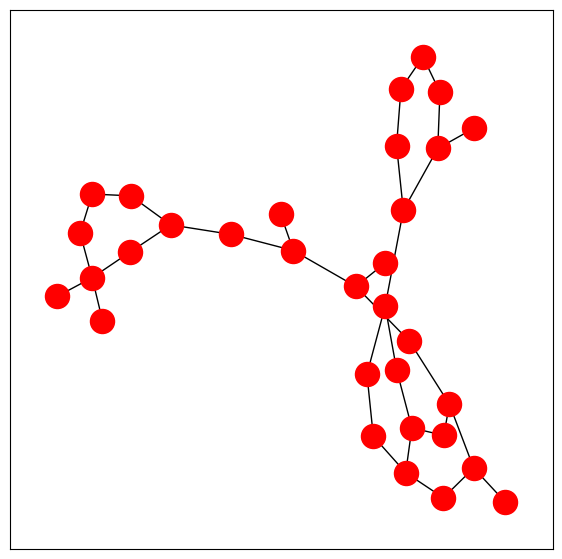

In [45]:
from torch_geometric.utils import to_networkx

G = to_networkx(graph, to_undirected=True)
visualize_graph(G, color="red")

 Node features shape :  torch.Size([32, 9])
 Edge indices shape :  torch.Size([2, 70])
 Edge attributes shape :  torch.Size([70, 3])
 Target :  tensor([[1.],
        [1.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]])


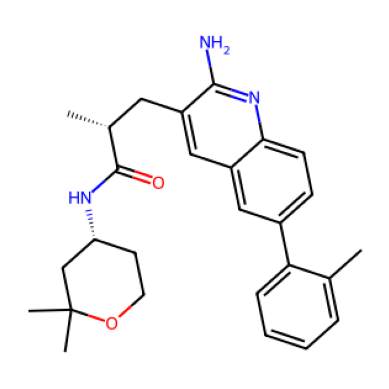

In [47]:
# Explore a single molecule
print ( " Node features shape : " , graph.x .shape )
print ( " Edge indices shape : " , graph.edge_index.shape )
print ( " Edge attributes shape : " , graph.edge_attr.shape )
print ( " Target : " , data.y )
# Visualize the molecule
smiles = graph.smiles # Get SMILES string
mol = rdkit.Chem . MolFromSmiles ( smiles )
img = rdkit.Chem.Draw . MolToImage ( mol , size =(300 , 300) )
plt . imshow (img)
plt . axis ('off')
plt . show ()